# Ariel collection
The ariel dataset collection apparatues is compries of a FLIR Tau2 camera and an IMU unit to measure the exact position and attitude of the camera.

## IMU
The device is built from the following parts:
1. [Arduino WiFi Rev2](https://store.arduino.cc/arduino-uno-wifi-rev2)
2. [Pololu AltIMU-10 v5](https://www.pololu.com/product/2739)
3. [SparkFun GPS shield GP3906-TLP](https://learn.sparkfun.com/tutorials/gps-logger-shield-hookup-guide/all)
   with [MediaTek MT3339](https://www.mediatek.com/products/locationIntelligence/mt3339) chip.
4. Wi-Fi dongle for the PC computer.

The IMU measures Gyro, Accelerometer, Magnetometer which are sampled at ~450Hz, and GPS which is sampled at 2Hz.

These measurements are later transformed into Roll, Pitch, Yaw using *Extended Kalman Filter* (EKF).

### Calibration
The EKF needs to be calibrated in order to provide a valid attitude estimation. The calibration is done using a calibration system we built:
1. [Arduino Uno Rev3](https://store.arduino.cc/arduino-uno-rev3)
2. [CNC Shield by Protoneer](http://info.protoneer.com/1)
3. Stepper driver DRV8825.
4. [Stepper 42BYGHM809](https://www.sparkfun.com/products/10846)
5. 12V power supply for the CNC shield.
6. Optical End-Stop (generic).
7. A thin protrude for the End-Stop.
8. Self-made spinning frame (seen in the images bellow).

The calibration process is as follows:
1. The IMU is connected to the frame *perpendicular* as much as possible to the spin direction.
2. Connect the End-Stop and the Stepper to the CNC shield.
3. The IMU logs the nanoseconds of each sample.
4. The End-Stop sends an interrupt that also saves the nanoseconds.
5. Both the Stepper and the IMU are controlled using Python.
6. The Stepper spins several full circles at preset speeds, in both directions of spin.


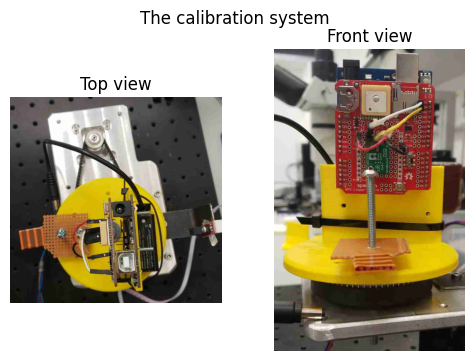

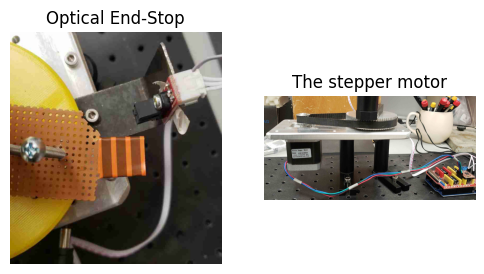

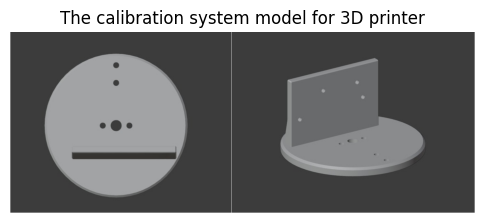

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
DPI = 100
opener = lambda x: np.array(Image.open(x))

fig, axs = plt.subplots(1,2, dpi=DPI)

axs[0].imshow(opener('images/calib/Top.jpg'))
axs[0].axis('off')
axs[0].set_title('Top view')

axs[1].imshow(opener('images/calib/Front.jpg'))
axs[1].axis('off')
axs[1].set_title('Front view')

fig.suptitle('The calibration system')

plt.show()
plt.close()

fig, axs = plt.subplots(1,2, dpi=DPI)

axs[0].imshow(opener('images/calib/EndStop.jpg'))
axs[0].axis('off')
axs[0].set_title('Optical End-Stop')

axs[1].imshow(opener('images/calib/Stepper.jpg'))
axs[1].axis('off')
axs[1].set_title('The stepper motor')

plt.show()
plt.close()


plt.figure(dpi=DPI)
plt.imshow(opener('images/calib/CalibModel.jpg'))
plt.axis('off')
plt.title('The calibration system model for 3D printer')
plt.show()
plt.close()

The measurements made by the IMU during calibration:

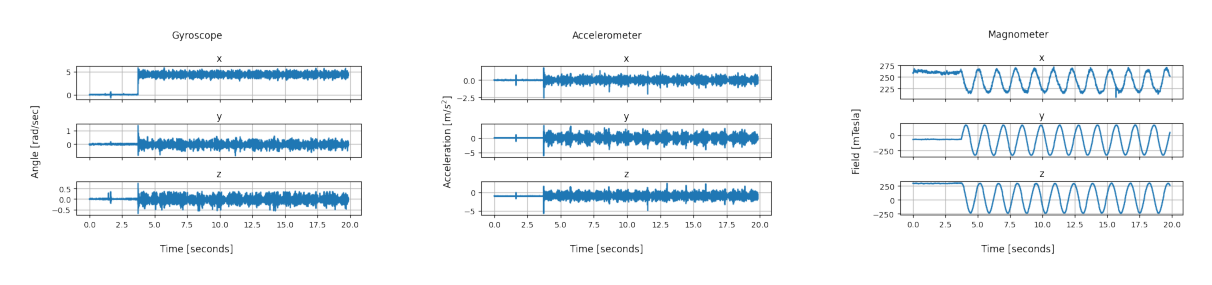

In [2]:
fig, axs = plt.subplots(1, 3, dpi=250)
axs[0].imshow(opener('images/calib/gyro.png'))
axs[0].axis('off')
axs[1].imshow(opener('images/calib/acc.png'))
axs[1].axis('off')
axs[2].imshow(opener('images/calib/mag.png'))
axs[2].axis('off')
plt.show()
plt.close()

The calibration system was first set to calibrate the *Roll* angle. As seen in the next figure, the initial results suffer from a 0.2 seconds delay. The Pitch and Yaw also suffer from some variability in the measurements, as anticipated by the inaccuracies in the calibration device itself.

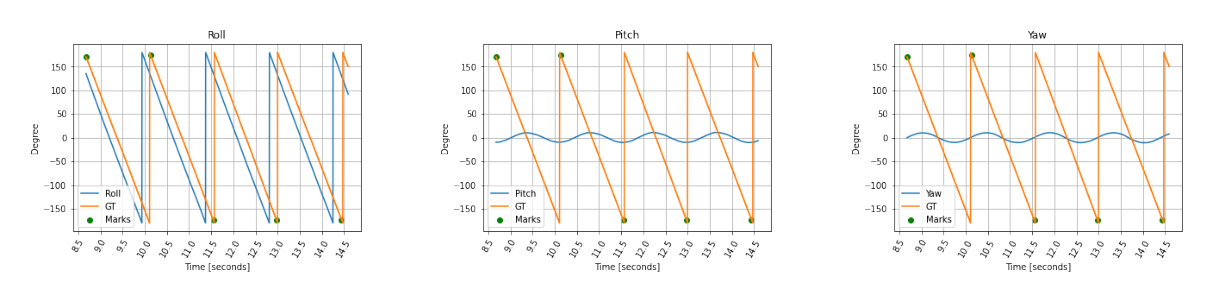

In [3]:
fig, axs = plt.subplots(1, 3, dpi=250)
axs[0].imshow(opener('images/calib/roll.png'))
axs[0].axis('off')
axs[1].imshow(opener('images/calib/pitch.png'))
axs[1].axis('off')
axs[2].imshow(opener('images/calib/yaw.png'))
axs[2].axis('off')
plt.show()
plt.close()

### Camera
The camera is FLIR Tau2. The camera outputs a 14-bit image of the radiation flux inflicted upon the Bolometer array.

All AGC have been shut off, by the help of FLIR themselves, to only receive the raw data acquired by the camera, without any processing.

# Land based collection

We built a system for collecting multispectral images built from a FLIR Tau2 camera, Thorlab LWIR filters and filter-wheel and a GUI. The next figure shows the web-based GUI we built for the system:

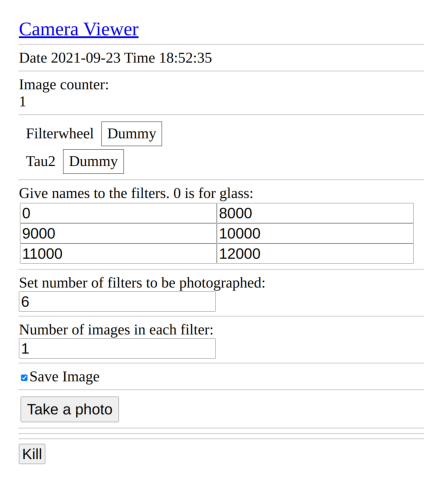

In [4]:
plt.figure(dpi=150)
plt.imshow(opener('images/gui.png'))
plt.axis('off')
plt.show()
plt.close()

# Vignetting
Vignetting occures when using the filters. This phenomenon is most likely due to the distance between the lens and the filters.

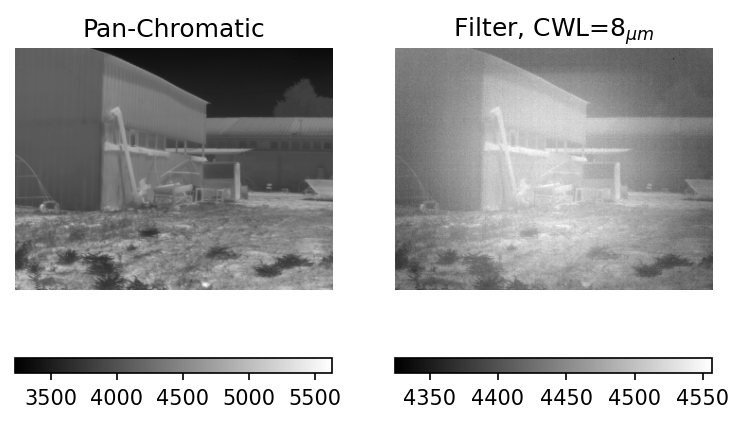

In [5]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

data = np.load(Path().cwd().parent.parent / 'data' / 'images' / 'img1_good.npy')
fig, axs = plt.subplots(1, 2, dpi=150)
im = axs[0].imshow(data[0, 0], cmap='gray')
axs[0].axis('off')
axs[0].set_title("Pan-Chromatic")
plt.colorbar(im, ax=axs[0], location='bottom')
im = axs[1].imshow(data[1, 0], cmap='gray')
axs[1].axis('off')
axs[1].set_title("Filter, CWL=8$_{\mu m}$")
plt.colorbar(im, ax=axs[1], location='bottom')
plt.show()
plt.close()

As seen, not only is there vignetting, but the filtered image also have a *higher* gray scale range, as opposed to the theory where less radiation should reach the lens when filtered. This issue will be addressed later.

# Physical Model
To tackle the observed issue, we must first assume some model the generated distortion in the grey-levels.
I propose the following linear model:
$$ GL^{(f)}_{i,j} = \alpha_{i,j}P^{(f)}(T) + \beta_{i,j}^{(f)} + n_{i,j}$$
Where:
* $GL^{(f)}_{i,j}$ are the grey level of the i,j'th pixel (per filter).
* $P^{(f)}(T)$ is the radiance power (per filter), which can be calculated analytically based on Plank's law.
* $\alpha_{i,j}$ are the per-pixel slopes of the liner model.
* $\beta_{i,j}^{(f)}$ is the linear model bias (perhaps not pixel-dependent).
* $n$ is the per-pixel additive noise.

We assume that $\alpha_{i,j}$ should be the same for all filters, including the case where no filter is applied (A.K.A the pan-chromatic case). Hence, we could use "undistorted" pan-chromatic acquisitions to estimate $\alpha_{i,j}$, and combined with plank's law, to estimate the expected filtered scenes. The difference between the estimated scenes and the de-facto acquired scenes will be the distortion that we are looking for.